In [49]:
import pandas as pd 
from bs4 import BeautifulSoup
from urllib.parse import quote
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import re

In [50]:
topic = pd.read_csv('./관광지상세정보url_merge.csv')

In [51]:
topic.head(1)

,관광지명,주소,상세정보,해시태그_sub,평균별점,주소_동별,연락처,위도,경도,해시태그,상세페이지_url
0,성산일출봉(UNESCO 세계자연유산),제주특별자치도 서귀포시 성산읍 일출로 284-12,성산일출봉은 제주도의 다른 오름들과는 달리 마그마가 물속에서 분출하면서 만들어진 수...,"일출,오름,경관,포토,부모,자연경관,포토스팟,유네스코,무장애관광,공영관광지",별점(5점만점에 5점),성산읍 성산리,(+82) 064-783-0959,33.462234,126.936801,"['#일출', '#오름', '#경관/포토', '#부모', '#자연경관', '#포토스...",https://www.visitjeju.net/kr/detail/view?conte...


In [4]:
topic['해시태그_sub'][0]

'일출,오름,경관,포토,부모,자연경관,포토스팟,유네스코,무장애관광,공영관광지'

In [5]:
web_stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

stopwords = set([])
for i in web_stopwords:
    stopwords.add(i[0])

len(stopwords)


# 불용어 추가
jeju_stopwords = ['제주', '제주도',  '리뷰', '숙소', '여행', '트립', '정말', '동안', '다음', '바로', '근처', '조금', '시간',
                   '호스트', '정도', '방문', '사장', '이용', '다시', '예약', '살이', '살기', '아주', '추천', '하루', '이번',
                   '처음', '달동', '저희', '하나', '사용', '모두', '진짜', '일주일', '보름', '선택', '시작', '한번', '가장', '마음',
                   '제외', '이동', '무엇', '준비', '그냥', '감사', '생각', '느낌', '덕분', '후기', '기회',  '다른', '여기', '우리',
                   '미스터', '미스터멘션', '멘션', '때문', '오늘', '도착', '보고', '마지막', '가지', '이제', '지금', '모습', '위해',
                   '타고', '사실', '포스팅', '주문', '역시', '침대', '거실', '매일', '출발', '소개', '기억', '참고', '계속', '객실',
                   '일차', '이야기', '요즘', '이유', '경우', '일단', '거의', '스텝', '제일', '자주', '어디', '마무리', '아래', '운영',
                   '이상', '의자', '별로', '원래', '중간', '뭔가', '첫째', '체크', '잠시', '언제', '살짝', '해도', '계단', '부분', '냉장고',
                    '침실', '기본', '제공', '일찍', '인테리어', '완전', '추가', '등등', '매우', '가야', '그때', '기간', '마치', '가득', '대부분',
                    '미리', '둘째', '근무', '공간', '스테이', '알파', '엄마', '아빠', '아들', '일정', '계획', '아침',
                     '점심', '저녁', '자리', '두리', '언니', '가격', '건물', '언니', 
                      '숙박', '만원', '가기', '독채','화장실', '욕실', '숙박', '세탁기', '코로나' ,
                     '주방', '도서관', '서울','티비', '트랙','이드','택트','입장',
                     '호텔', '펜션', '게스트하우스']
for word in jeju_stopwords:
    stopwords.add(word)

In [6]:
from konlpy.tag import Okt
from collections import Counter
okt = Okt()

In [7]:
def hangul_function(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [8]:
temp_list = []
for blog in topic['해시태그_sub']:
    LDA_nous = okt.nouns(hangul_function(blog))
    LDA_nous = [x for x in LDA_nous if len(x) > 1 or x =='봄']  # 한글자 키워드 제거    
    LDA_nous = [word for word in LDA_nous if not word in stopwords]
    temp_list.append(LDA_nous)

In [9]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric

import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [31]:
temp_list = []
for blog in topic['해시태그_sub']:
    LDA_nous = okt.nouns(hangul_function(blog))
    LDA_nous = [x for x in LDA_nous if len(x) > 1 or x =='봄']  # 한글자 키워드 제거    
    LDA_nous = [word for word in LDA_nous if not word in stopwords]
    temp_list.append(LDA_nous)

dictionary = corpora.Dictionary(temp_list)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpus_test = [dictionary.doc2bow(text) for text in temp_list]

num_topics = 6
#각 학습청크에서 한번에 처리되는 문서의 수. 값이 클수록 훈련속도 up많은 메모리 필요할수도 있음.
# 값이 작을수록 더 정확한 결과를 얻을 수 있지만 훈련속도가 느려질수 있고 일반적인 값은 약 2000
chunksize = 2000 
# 학습중에 전체 말뭉치가 처리되는 횟수. 패스 수를 늘리면 더 정확한 모델을 만들 수 있지만 더 많은
# 더 많은  계산이 필요함. 일반적인 값은 약20.
passes = 20
#  각 패스내에서 모델 매개변수를 업데이트하기 위한 반복횟수. 일반적인 값은 약 400
iterations = 400
#  지정된 경우 모델 당혹도는 반복마다 평가됨. 복잡도는 모형이 보류된 테스트 세트를 얼마나 잘 예측하는지를
# 측정한 것. 이 매개변수를 설정하면 모델의 수렴을 모니터링하는데 도움이 될수있음.
#  'None'인 경우, 훈련 중에 복잡도가 계산되지 않음.
eval_every = None


temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus_test,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

lda_visualization = gensimvis.prepare(model, corpus_test, dictionary, sort_topics=True,)
pyLDAvis.save_html(lda_visualization, './result/topicmodeling3.html')

In [68]:
top_topics = model.top_topics(corpus_test)

avg_topic_coherence = sum([t[1] for t in top_topics])/ num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -4.8560.
[([(0.1489705, '경관'),
   (0.14202963, '포토'),
   (0.07329614, '스팟'),
   (0.0688643, '자연'),
   (0.06287462, '맑음'),
   (0.050542213, '커플'),
   (0.041075863, '해변'),
   (0.028239721, '휴식'),
   (0.028074248, '친구'),
   (0.025182813, '힐링'),
   (0.024015935, '여름'),
   (0.01758196, '관광지'),
   (0.017324643, '어린이'),
   (0.01578983, '부모'),
   (0.015500954, '일몰'),
   (0.012077695, '봄'),
   (0.012026432, '일출'),
   (0.011995355, '드라이브'),
   (0.010747567, '관광'),
   (0.010395023, '가을')],
  -2.05196144283812),
 ([(0.13838029, '도보'),
   (0.07147896, '경관'),
   (0.070356175, '자연'),
   (0.062125552, '친구'),
   (0.056753732, '걷기'),
   (0.05400304, '등산'),
   (0.050628617, '오름'),
   (0.044980302, '커플'),
   (0.033140045, '맑음'),
   (0.030902838, '부모'),
   (0.029404532, '휴식'),
   (0.026518017, '문화'),
   (0.025422119, '관광'),
   (0.024704045, '박물관'),
   (0.020944672, '힐링'),
   (0.019701844, '미술'),
   (0.017933773, '어린이'),
   (0.015590487, '관광지'),
   (0.014728248, '올레'),
   (0.0122873

In [72]:
model.print_topics(num_words=20)

[(0,
  '0.149*"경관" + 0.142*"포토" + 0.073*"스팟" + 0.069*"자연" + 0.063*"맑음" + 0.051*"커플" + 0.041*"해변" + 0.028*"휴식" + 0.028*"친구" + 0.025*"힐링" + 0.024*"여름" + 0.018*"관광지" + 0.017*"어린이" + 0.016*"부모" + 0.016*"일몰" + 0.012*"봄" + 0.012*"일출" + 0.012*"드라이브" + 0.011*"관광" + 0.010*"가을"'),
 (1,
  '0.272*"반려동물" + 0.068*"카페" + 0.064*"동반" + 0.055*"식당" + 0.052*"라떼" + 0.032*"음식" + 0.029*"반입" + 0.015*"아메리카노" + 0.013*"카페라떼" + 0.012*"바닐라" + 0.012*"애견" + 0.009*"에스프레소" + 0.009*"스무디" + 0.009*"크림" + 0.008*"초코" + 0.007*"커피" + 0.007*"자몽" + 0.006*"주스" + 0.006*"애견미용실" + 0.006*"튀김"'),
 (2,
  '0.129*"관광" + 0.118*"관광지" + 0.108*"실내" + 0.081*"체험" + 0.056*"무장애" + 0.054*"테마" + 0.052*"어린이" + 0.031*"사계절" + 0.023*"공원" + 0.022*"겨울" + 0.019*"러닝" + 0.018*"홀리데이인" + 0.018*"안전" + 0.017*"업체" + 0.016*"스탬프" + 0.015*"아이비" + 0.014*"우수" + 0.011*"서귀포" + 0.008*"커플" + 0.007*"전시"'),
 (3,
  '0.138*"도보" + 0.071*"경관" + 0.070*"자연" + 0.062*"친구" + 0.057*"걷기" + 0.054*"등산" + 0.051*"오름" + 0.045*"커플" + 0.033*"맑음" + 0.031*"부모" + 0.029*"휴식" + 0.027*"문화" + 0

In [73]:
df_topic = pd.DataFrame(model.print_topics(num_words=20))
df_topic.columns = ['group', 'topic']
df_topic

,group,topic
0,0,"0.149*""경관"" + 0.142*""포토"" + 0.073*""스팟"" + 0.069*""..."
1,1,"0.272*""반려동물"" + 0.068*""카페"" + 0.064*""동반"" + 0.055..."
2,2,"0.129*""관광"" + 0.118*""관광지"" + 0.108*""실내"" + 0.081*..."
3,3,"0.138*""도보"" + 0.071*""경관"" + 0.070*""자연"" + 0.062*""..."
4,4,"0.171*""문화"" + 0.114*""관광"" + 0.108*""유적지"" + 0.098*..."
5,5,"0.189*""체험"" + 0.089*""레저"" + 0.076*""반려동물"" + 0.029..."


In [76]:
temp = df_topic['topic'].str.split('+', expand=True)
for i in range(20):    
    temp.rename(columns= {i: f'topic_{i}'}, inplace= True)
    temp[[f'topic_{i}_rate', f'topic_{i}_key']] = temp[f'topic_{i}'].str.split('*', expand=True)
    temp.drop(columns= f'topic_{i}', inplace=True)
    temp[f'topic_{i}_key'] = temp[f'topic_{i}_key'].apply(lambda x: x.replace('"', ''))


In [77]:
temp.reset_index(inplace=True)
temp.rename(columns={'index' : 'group'}, inplace=True)
temp

,group,topic_0_rate,topic_0_key,topic_1_rate,topic_1_key,topic_2_rate,topic_2_key,topic_3_rate,topic_3_key,topic_4_rate,...,topic_15_rate,topic_15_key,topic_16_rate,topic_16_key,topic_17_rate,topic_17_key,topic_18_rate,topic_18_key,topic_19_rate,topic_19_key
0,0,0.149,경관,0.142,포토,0.073,스팟,0.069,자연,0.063,...,0.012,봄,0.012,일출,0.012,드라이브,0.011,관광,0.010,가을
1,1,0.272,반려동물,0.068,카페,0.064,동반,0.055,식당,0.052,...,0.007,커피,0.007,자몽,0.006,주스,0.006,애견미용실,0.006,튀김
2,2,0.129,관광,0.118,관광지,0.108,실내,0.081,체험,0.056,...,0.015,아이비,0.014,우수,0.011,서귀포,0.008,커플,0.007,전시
3,3,0.138,도보,0.071,경관,0.070,자연,0.062,친구,0.057,...,0.020,미술,0.018,어린이,0.016,관광지,0.015,올레,0.012,사계절
4,4,0.171,문화,0.114,관광,0.108,유적지,0.098,역사,0.098,...,0.006,체험,0.006,김치찌개,0.006,돼지,0.005,커플,0.005,부모
5,5,0.189,체험,0.089,레저,0.076,반려동물,0.029,맑음,0.027,...,0.012,반입,0.012,바비큐,0.011,캠핑,0.010,승마,0.010,와이파이존


In [81]:
topic_240112_1 = temp

In [39]:
# topic_240112_1 = pd.DataFrame(top_topics, columns=['Coherence Score', 'Representative Words'])

In [83]:
topic_240112_1.to_csv('./240112_topic_1.csv', index=False)

In [84]:
pd.read_csv('./240112_topic_1.csv' )

,group,topic_0_rate,topic_0_key,topic_1_rate,topic_1_key,topic_2_rate,topic_2_key,topic_3_rate,topic_3_key,topic_4_rate,...,topic_15_rate,topic_15_key,topic_16_rate,topic_16_key,topic_17_rate,topic_17_key,topic_18_rate,topic_18_key,topic_19_rate,topic_19_key
0,0,0.149,경관,0.142,포토,0.073,스팟,0.069,자연,0.063,...,0.012,봄,0.012,일출,0.012,드라이브,0.011,관광,0.010,가을
1,1,0.272,반려동물,0.068,카페,0.064,동반,0.055,식당,0.052,...,0.007,커피,0.007,자몽,0.006,주스,0.006,애견미용실,0.006,튀김
2,2,0.129,관광,0.118,관광지,0.108,실내,0.081,체험,0.056,...,0.015,아이비,0.014,우수,0.011,서귀포,0.008,커플,0.007,전시
3,3,0.138,도보,0.071,경관,0.070,자연,0.062,친구,0.057,...,0.020,미술,0.018,어린이,0.016,관광지,0.015,올레,0.012,사계절
4,4,0.171,문화,0.114,관광,0.108,유적지,0.098,역사,0.098,...,0.006,체험,0.006,김치찌개,0.006,돼지,0.005,커플,0.005,부모
5,5,0.189,체험,0.089,레저,0.076,반려동물,0.029,맑음,0.027,...,0.012,반입,0.012,바비큐,0.011,캠핑,0.010,승마,0.010,와이파이존


클러스터링!!

In [85]:
# !pip install matplotlib seaborn sklearn konlpy scikit-learn wordcloud pyLDAvis gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from wordcloud import WordCloud, STOPWORDS

from konlpy.tag import Okt
okt = Okt() 
from collections import Counter

In [86]:
topic = pd.read_csv('./관광지상세정보url_merge.csv')

In [87]:
stopwords = set([])

web_stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
web_stopwords[:10]

for i in web_stopwords:
    stopwords.add(i[0])

print(len(stopwords))

jeju_stopwords = ['제주', '제주도',  '리뷰', '숙소', '여행', '트립', '정말', '동안', '다음', '바로', '근처', '조금', '시간',
                   '호스트', '정도', '방문', '사장', '이용', '다시', '예약', '살이', '살기', '아주', '추천', '하루', '이번',
                   '처음', '달동', '저희', '하나', '사용', '모두', '진짜', '일주일', '보름', '선택', '시작', '한번', '가장', '마음',
                   '제외', '이동', '무엇', '준비', '그냥', '감사', '생각', '느낌', '덕분', '후기', '기회',  '다른', '여기', '우리',
                   '미스터', '미스터멘션', '멘션', '때문', '오늘', '도착', '보고', '마지막', '가지', '이제', '지금', '모습', '위해',
                   '타고', '사실', '포스팅', '주문', '역시', '침대', '거실', '매일', '출발', '소개', '기억', '참고', '계속', '객실',
                   '일차', '이야기', '요즘', '이유', '경우', '일단', '거의', '스텝', '제일', '자주', '어디', '마무리', '아래', '운영',
                   '이상', '의자', '별로', '원래', '중간', '뭔가', '첫째', '체크', '잠시', '언제', '살짝', '해도', '계단', '부분', '냉장고',
                    '침실', '기본', '제공', '일찍', '인테리어', '완전', '추가', '등등', '매우', '가야', '그때', '기간', '마치', '가득', '대부분',
                    '미리', '둘째', '근무', '공간', '스테이', '알파', '엄마', '아빠', '아들', '일정', '계획', '아침',
                     '점심', '저녁', '자리', '두리', '언니', '가격', '건물', '언니', 
                      '숙박', '만원', '가기', '독채','화장실', '욕실', '숙박', '세탁기', '코로나' ,
                     '주방', '도서관', '서울','티비', '트랙','이드','택트','입장',
                     '호텔', '펜션', '게스트하우스']
for word in jeju_stopwords:
    stopwords.add(word)

594


In [88]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1 or x =='봄']  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(topic['해시태그_sub'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

c:\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [89]:
word_list

array(['가가', '가능', '가든', ..., '휴양', '휴양림', '힐링'], dtype=object)

In [90]:
columns = []
for k, v in sorted(vect.vocabulary_.items(), key=lambda item:item[1]): 
  columns.append(k)

df = pd.DataFrame(bow_vect.toarray(), columns = columns) # DTM 만들기
df_tdm = df.T

In [91]:
df_tdm

,0,1,2,3,4,5,6,7,8,9,...,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483
가가,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가능,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가든,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가라아게,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가빈,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
훈제,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
휴식,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
휴양,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
휴양림,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
import matplotlib.pyplot as plt
plt.rc('font', family='malgun Gothic')

In [105]:
df_tdm['total'] = df_tdm.sum(axis=1)     # 단어 총 빈도수 계산
df_words = df_tdm[df_tdm['total'].rank(ascending=False) <= 50] # 빈도수 상위 50개 추출
df_words= df_words.drop('total', axis=1)    # 컬럼 'total' 제거
df_words[:5]

,0,1,2,3,4,5,6,7,8,9,...,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483
가을,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
걷기,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
겨울,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
경관,2,2,1,2,1,1,2,1,1,2,...,0,0,0,2,0,0,1,2,0,0
공원,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt

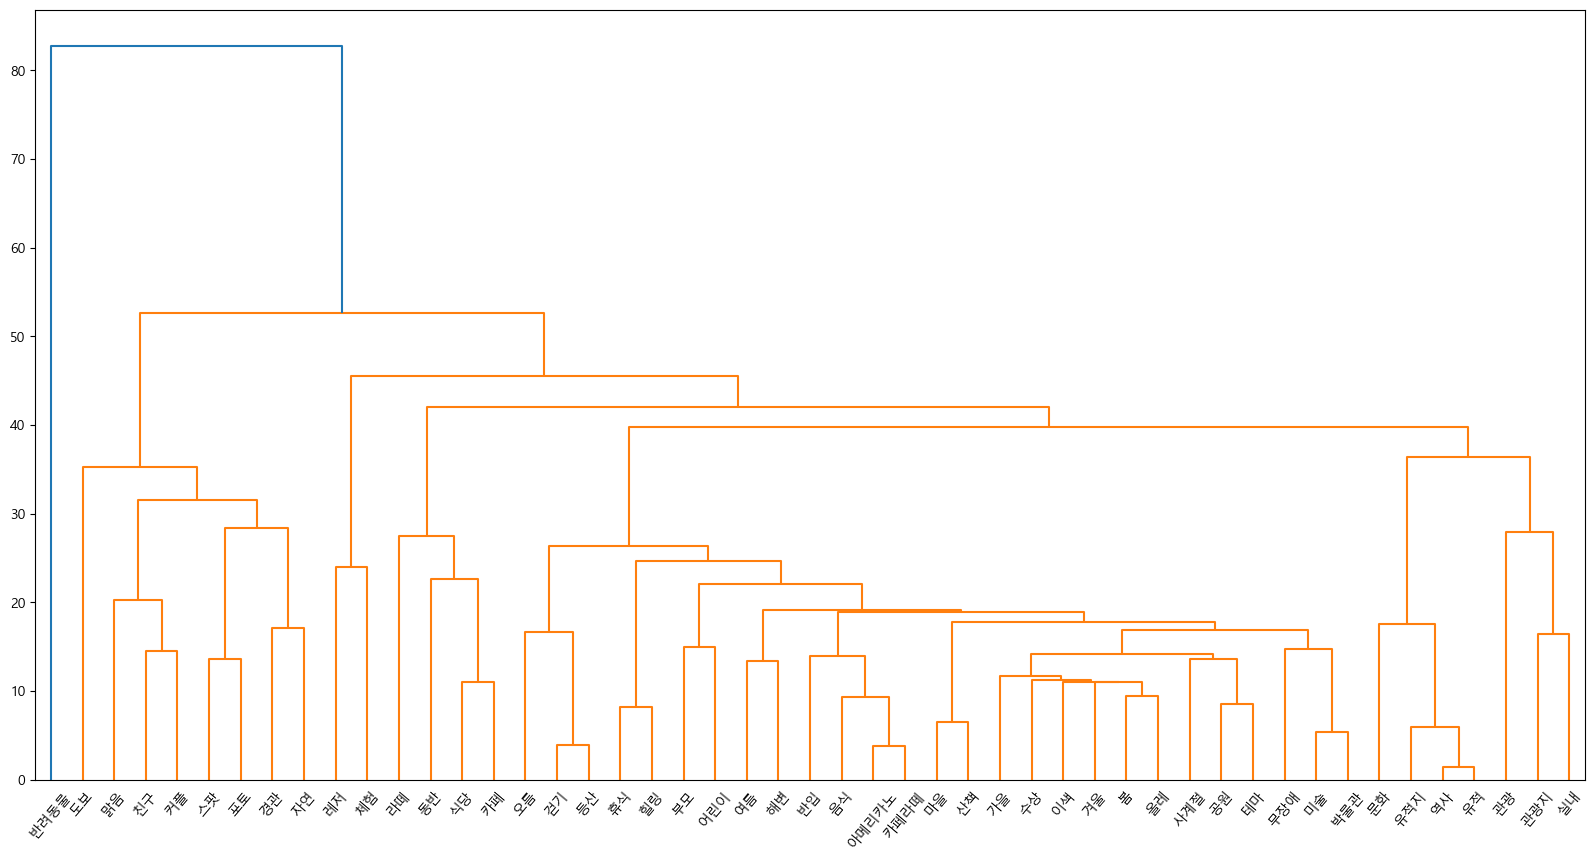

In [106]:
# 군집 방식은 ward로 거리는 유크리디안으로 측정해 군집분석

clusters = linkage(df_words, method='ward', metric='euclidean')

# 덴드로그램 그리기

plt.figure(figsize=(20, 10))               # 이미지 크기 설정
dendrogram(clusters,
           leaf_rotation=50,               # 라벨 50% 기울리기
           leaf_font_size=10,              # 라벨 폰트 크기
           labels=df_words.index)          # 라벨에 사용할 변수
plt.savefig('./result/240112_hier.png')

In [107]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
predict = ward.fit_predict(df_words)      # 군집 3개 분리값(0, 1, 2)
df_words['predict'] = predict             # 해당 군집값(0, 1, 2)을 원본 데이터에 붙이기
df_words[:5]

c:\Python39\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,1475,1476,1477,1478,1479,1480,1481,1482,1483,predict
가을,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,5
걷기,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,5
겨울,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
경관,2,2,1,2,1,1,2,1,1,2,...,0,0,2,0,0,1,2,0,0,2
공원,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [108]:
cluster_1 = df_words[df_words['predict'] == 0].index
print("군집 1: ", cluster_1)
cluster_2 = df_words[df_words['predict'] == 1].index
print("군집 2: ", cluster_2)
cluster_3 = df_words[df_words['predict'] == 2].index
print("군집 3: ", cluster_3)
cluster_4 = df_words[df_words['predict'] == 3].index
print("군집 4: ", cluster_4)
cluster_5 = df_words[df_words['predict'] == 4].index
print("군집 5: ", cluster_5)
cluster_6 = df_words[df_words['predict'] == 5].index
print("군집 6: ", cluster_6)
# cluster_7 = df_words[df_words['predict'] == 6].index
# print("군집 7: ", cluster_7)

군집 1:  Index(['관광', '관광지', '문화', '실내', '역사', '유적', '유적지'], dtype='object')
군집 2:  Index(['동반', '라떼', '식당', '카페'], dtype='object')
군집 3:  Index(['경관', '도보', '맑음', '스팟', '자연', '친구', '커플', '포토'], dtype='object')
군집 4:  Index(['반려동물'], dtype='object')
군집 5:  Index(['레저', '체험'], dtype='object')
군집 6:  Index(['가을', '걷기', '겨울', '공원', '등산', '마을', '무장애', '미술', '박물관', '반입', '봄', '부모',
       '사계절', '산책', '수상', '아메리카노', '어린이', '여름', '오름', '올레', '음식', '이색', '카페라떼',
       '테마', '해변', '휴식', '힐링'],
      dtype='object')


In [109]:
temp_hier = []
for i in range(6):
    temp = i, df_words[df_words['predict'] == i].index.to_list()
    temp_hier.append(temp)

df_hier = pd.DataFrame(temp_hier)
df_hier.columns = ['group', 'keyword']
df_hier 

df_hier.to_csv('./result/240112_hier.csv', index= False)



In [110]:
df_hier 

,group,keyword
0,0,"[관광, 관광지, 문화, 실내, 역사, 유적, 유적지]"
1,1,"[동반, 라떼, 식당, 카페]"
2,2,"[경관, 도보, 맑음, 스팟, 자연, 친구, 커플, 포토]"
3,3,[반려동물]
4,4,"[레저, 체험]"
5,5,"[가을, 걷기, 겨울, 공원, 등산, 마을, 무장애, 미술, 박물관, 반입, 봄, ..."


k-means

In [120]:
### K - Means
df_tdm['total'] = df_tdm.sum(axis=1)     # 단어 총 빈도수 계산
df_words = df_tdm[df_tdm['total'].rank(ascending=False) <= 50] # 빈도수 상위 50개 추출
df_words= df_words.drop('total', axis=1)    # 컬럼 'total' 제거
df_words[:6]

,0,1,2,3,4,5,6,7,8,9,...,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483
가을,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
걷기,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
겨울,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
경관,2,2,1,2,1,1,2,1,1,2,...,0,0,0,2,0,0,1,2,0,0
공원,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
관광,1,1,0,1,0,1,0,2,0,1,...,0,1,1,1,0,1,0,0,0,0


In [121]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters= 6)   # default: euclidean 거리
predict = kmeans.fit_predict(df_words)    # k-means 분석으로 군집 3개 분리(0, 1, 2)     
df_words['predict'] = predict             # 해당 군집값(0, 1, 2)을 원본 데이터에 붙이기
print(df_words[:6])

    0  1  2  3  4  5  6  7  8  9  ...  1475  1476  1477  1478  1479  1480  \
가을  0  0  0  0  0  0  0  1  0  1  ...     0     0     0     0     0     0   
걷기  0  0  1  0  0  0  0  1  1  0  ...     0     0     0     0     0     0   
겨울  0  0  0  1  0  0  0  0  0  0  ...     0     0     0     0     0     0   
경관  2  2  1  2  1  1  2  1  1  2  ...     0     0     2     0     0     1   
공원  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
관광  1  1  0  1  0  1  0  2  0  1  ...     1     1     1     0     1     0   

    1481  1482  1483  predict  
가을     0     0     0        3  
걷기     0     0     0        3  
겨울     0     0     0        3  
경관     2     0     0        2  
공원     0     0     0        3  
관광     0     0     0        4  

[6 rows x 1485 columns]


c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [122]:
# 주성분 분석(PCA)을 이용해 단어별 x, y 좌표 얻기

from sklearn.decomposition import PCA

pca = PCA(n_components=2)                         # 2차원 PCA 모델 설정
word_pca = pca.fit_transform(df_words.iloc[0:, :-1])    # 군집 변수('predict')를 제외하고 PCA 실행)
df_pca = pd.DataFrame(data=word_pca, index=[df_words.index], columns=['main1', 'main2'])
df_pca['predict']= predict
df_pca.tail()

,main1,main2,predict
테마,-2.059876,-3.202948,3
포토,-3.327152,14.483993,3
해변,-1.651919,0.771809,3
휴식,-2.569739,1.345582,3
힐링,-2.555624,0.018150,3


c:\Python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
c:\Python39\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_22320\1497128748.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_pca.main1[i], df_pca.main2[i], index)
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_22320\1497128748.py:10: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('./result/240112_kmeans.png')
c:\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(byte

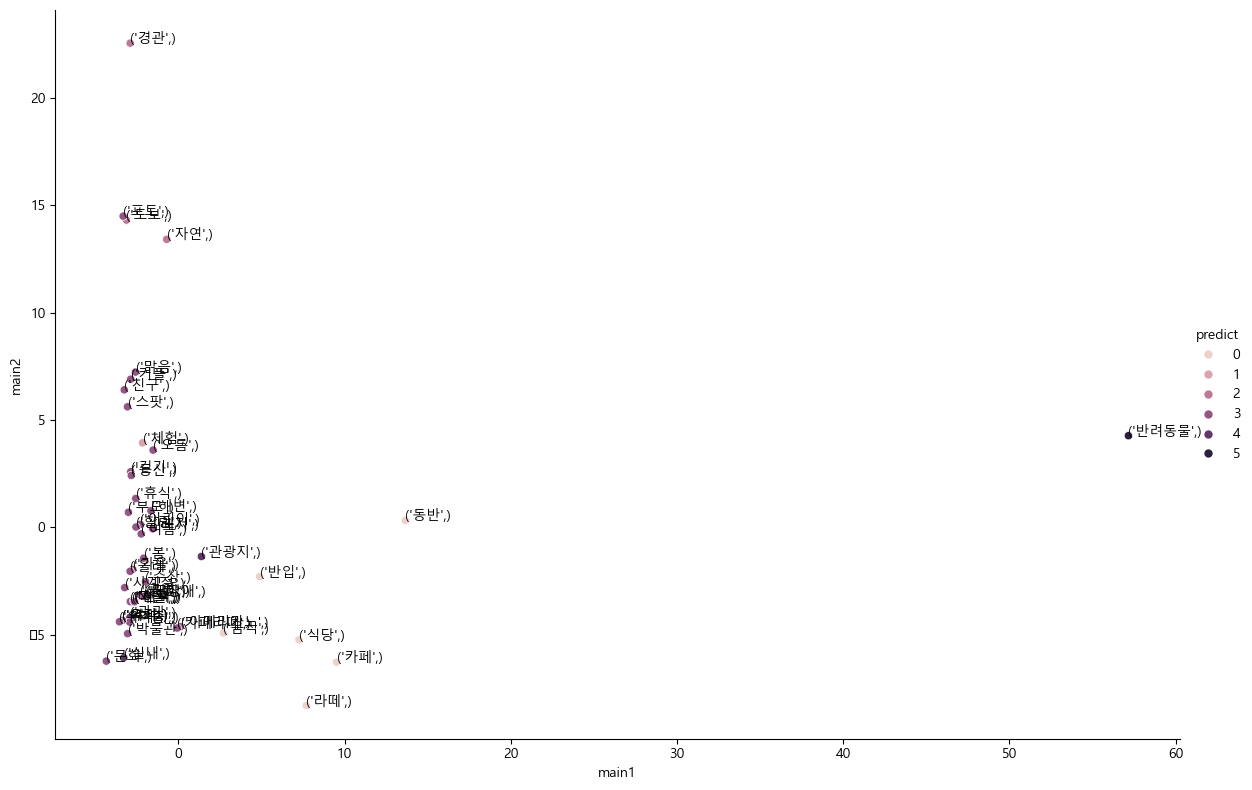

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn을 이용해 산점도 그리기
sns.relplot(data = df_pca, x='main1',y= 'main2', height =8, aspect=1.5, hue='predict') 

# 산점도에 라벨링하기
for i, index in enumerate(df_pca.index):
  plt.text(df_pca.main1[i], df_pca.main2[i], index)
plt.savefig('./result/240112_kmeans.png') 

In [125]:
cluster_1 = df_pca[df_pca['predict'] == 0].index
print("군집 1: ", cluster_1)
cluster_2 = df_pca[df_pca['predict'] == 1].index
print("군집 2: ", cluster_2)
cluster_3 = df_pca[df_pca['predict'] == 2].index
print("군집 3: ", cluster_3)
cluster_4 = df_pca[df_pca['predict'] == 3].index
print("군집 4: ", cluster_4)
cluster_5 = df_pca[df_pca['predict'] == 4].index
print("군집 5: ", cluster_5)
cluster_6 = df_pca[df_pca['predict'] == 5].index
print("군집 6: ", cluster_6)

군집 1:  MultiIndex([('동반',),
            ('라떼',),
            ('반입',),
            ('식당',),
            ('음식',),
            ('카페',)],
           )
군집 2:  MultiIndex([('체험',)],
           )
군집 3:  MultiIndex([('경관',),
            ('도보',),
            ('자연',)],
           )
군집 4:  MultiIndex([(   '가을',),
            (   '걷기',),
            (   '겨울',),
            (   '공원',),
            (   '등산',),
            (   '레저',),
            (   '마을',),
            (   '맑음',),
            (  '무장애',),
            (   '문화',),
            (   '미술',),
            (  '박물관',),
            (    '봄',),
            (   '부모',),
            (  '사계절',),
            (   '산책',),
            (   '수상',),
            (   '스팟',),
            ('아메리카노',),
            (  '어린이',),
            (   '여름',),
            (   '역사',),
            (   '오름',),
            (   '올레',),
            (   '유적',),
            (  '유적지',),
            (   '이색',),
            (   '친구',),
            ( '카페라떼',),
            (   '커플',),


In [126]:
temp_kmean = []
for i in range(6):
    temp = i, df_words[df_words['predict'] == i].index.to_list()
    temp_kmean.append(temp)

df_kmean = pd.DataFrame(temp_kmean)
df_kmean.columns = ['group', 'keyword']
df_kmean 

,group,keyword
0,0,"[동반, 라떼, 반입, 식당, 음식, 카페]"
1,1,[체험]
2,2,"[경관, 도보, 자연]"
3,3,"[가을, 걷기, 겨울, 공원, 등산, 레저, 마을, 맑음, 무장애, 문화, 미술, ..."
4,4,"[관광, 관광지, 실내]"
5,5,[반려동물]


In [127]:
df_kmean.to_csv('./result/240112_kmeans.csv', index=False)